In [ ]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

In [16]:
EPOCHS = 20
BATCH_SIZE = 64
LATENT_DIM = 100
IMAGE_SIZE = 28 * 28

In [17]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(LATENT_DIM, 128), 
            nn.ReLU(),
            nn.Linear(128, 256), 
            nn.ReLU(),
            nn.Linear(256, 512), 
            nn.ReLU(),
            nn.Linear(512, IMAGE_SIZE), 
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(IMAGE_SIZE, 512), 
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256), 
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [19]:
generator = Generator()
discriminator = Discriminator()
loss_fn = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)


In [20]:
for epoch in range(EPOCHS):
    for real_images, _ in train_loader:
        # Flatten real images
        real_images = real_images.view(-1, IMAGE_SIZE)
        batch_size = real_images.size(0)

        # Create real and fake labels
        labels_real = torch.ones(batch_size, 1)
        labels_fake = torch.zeros(batch_size, 1)

        # Train Discriminator
        noise = torch.randn(batch_size, LATENT_DIM)
        generated_images = generator(noise)

        # Discriminator predictions
        predictions_real = discriminator(real_images)
        predictions_fake = discriminator(generated_images.detach())

        # Loss for real and fake
        loss_real = loss_fn(predictions_real, labels_real)
        loss_fake = loss_fn(predictions_fake, labels_fake)
        discriminator_loss = loss_real + loss_fake

        d_optimizer.zero_grad()
        discriminator_loss.backward()
        d_optimizer.step()

        # Train Generator
        predictions_generated = discriminator(generated_images)
        generator_loss = loss_fn(predictions_generated, labels_real)

        g_optimizer.zero_grad()
        generator_loss.backward()
        g_optimizer.step()
    print(f"Epoch {epoch+1}/{EPOCHS} | D Loss: {discriminator_loss.item():.4f} | G Loss: {generator_loss.item():.4f}")


Epoch 1/20 | D Loss: 0.7193 | G Loss: 6.6177
Epoch 2/20 | D Loss: 0.6041 | G Loss: 2.9490
Epoch 3/20 | D Loss: 0.5080 | G Loss: 3.3228
Epoch 4/20 | D Loss: 0.2953 | G Loss: 4.8680
Epoch 5/20 | D Loss: 0.1262 | G Loss: 4.1095
Epoch 6/20 | D Loss: 0.1337 | G Loss: 3.5267
Epoch 7/20 | D Loss: 0.5025 | G Loss: 8.5862
Epoch 8/20 | D Loss: 0.6419 | G Loss: 4.9326
Epoch 9/20 | D Loss: 0.0479 | G Loss: 6.3547
Epoch 10/20 | D Loss: 0.4087 | G Loss: 5.3829
Epoch 11/20 | D Loss: 0.2430 | G Loss: 4.8910
Epoch 12/20 | D Loss: 0.3072 | G Loss: 3.7230
Epoch 13/20 | D Loss: 0.1418 | G Loss: 3.5641
Epoch 14/20 | D Loss: 0.3094 | G Loss: 4.4853
Epoch 15/20 | D Loss: 0.2422 | G Loss: 4.6769
Epoch 16/20 | D Loss: 0.2433 | G Loss: 4.9582
Epoch 17/20 | D Loss: 0.5182 | G Loss: 3.2541
Epoch 18/20 | D Loss: 0.3020 | G Loss: 4.0650
Epoch 19/20 | D Loss: 0.3600 | G Loss: 4.3340
Epoch 20/20 | D Loss: 0.1847 | G Loss: 4.4896


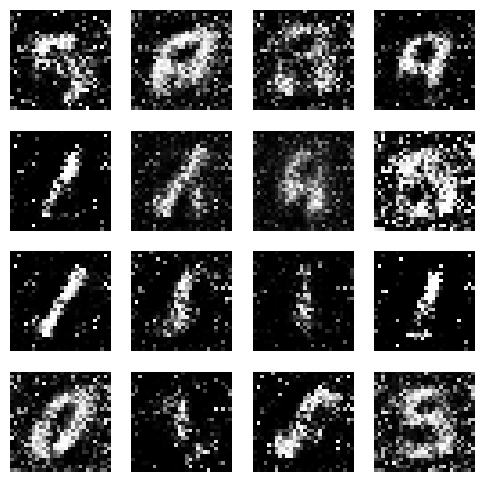

In [21]:
z = torch.randn(16, LATENT_DIM)
samples = generator(z).view(-1, 28, 28).detach()
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i], cmap='gray')
    ax.axis('off')
plt.show()


### Контрольні питання

**1. Що таке GAN і з чого вона складається?**

GAN (Generative Adversarial Network) — це тип нейронної мережі, який навчається генерувати нові дані, подібні до тих, що в навчальному наборі. Вона складається з двох частин:
Генератор (G) — генерує фейкові дані зі випадкового шуму.
Дискримінатор (D) — намагається відрізнити справжні дані від згенерованих.

**2. У чому полягає змагання між G і D?**

Генератор намагається створити такі дані, які дискримінатор не зможе відрізнити від справжніх.
Дискримінатор намагається правильно класифікувати дані як справжні або фейкові.
Це змагання змушує обидві мережі покращуватись: генератор стає кращим у "обмані", а дискримінатор — у виявленні фейків.

**3. Яку роль відіграє функція втрат у GAN?**

Функція втрат визначає, наскільки добре кожна з мереж виконує своє завдання:
Для генератора: функція втрат показує, наскільки успішно він "обдурив" дискримінатор.
Для дискримінатора: вона показує, наскільки точно він відрізнив справжні зразки від фейкових.

**4. Як уникнути mode collapse?**

Mode collapse — це проблема, коли генератор починає генерувати одні й ті ж або дуже схожі приклади, втрачаючи різноманітність.
Щоб цього уникнути:
- Використовують усереднені градієнти або minibatch discrimination.
- Впроваджують Wasserstein GAN (WGAN) з gradient penalty.
- Регулярно вносять шум у дискримінатор або підмішують фейкові мітки.
- Застосовують label smoothing (пом’якшення міток).


**5. У чому різниця між генератором і дискримінатором?**

| Генератор (G)| Дискримінатор (D)|
|--------------------------------------------|---------------------------------------------|
| Генерує нові дані з випадкового шуму | Визначає, чи дані справжні чи фейкові|
| Навчається "обманювати" дискримінатор | Навчається правильно розпізнавати дані|
| Вихід: штучно створені приклади | Вихід: ймовірність (реальність зразка)|
| Архітектура схожа на декодер/генератор | Архітектура схожа на класифікатор|
